In [1]:
import math
import torch
from torch import nn


class NewGELUActivation(nn.Module):
    def forward(self, input):
        return (
            0.5
            * input
            * (
                1.0
                + torch.tanh(
                    math.sqrt(2.0 / math.pi)
                    * (input + 0.044715 * torch.pow(input, 3.0))
                )
            )
        )


class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(
            self.num_channels,
            self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size,
        )

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"])
        )
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias,
            )
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat(
            [attention_output for attention_output, _ in attention_outputs], dim=-1
        )
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack(
                [attention_probs for _, attention_probs in attention_outputs], dim=1
            )
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = config["qkv_bias"]
        self.qkv_projection = nn.Linear(
            self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias
        )
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        qkv = self.qkv_projection(x)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        batch_size, sequence_length, _ = query.size()
        query = query.view(
            batch_size,
            sequence_length,
            self.num_attention_heads,
            self.attention_head_size,
        ).transpose(1, 2)
        key = key.view(
            batch_size,
            sequence_length,
            self.num_attention_heads,
            self.attention_head_size,
        ).transpose(1, 2)
        value = value.view(
            batch_size,
            sequence_length,
            self.num_attention_heads,
            self.attention_head_size,
        ).transpose(1, 2)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        attention_output = (
            attention_output.transpose(1, 2)
            .contiguous()
            .view(batch_size, sequence_length, self.all_head_size)
        )
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = self.attention(
            self.layernorm_1(x), output_attentions=output_attentions
        )
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(
            embedding_output, output_attentions=output_attentions
        )
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(
                module.weight, mean=0.0, std=self.config["initializer_range"]
            )
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(
    batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None
):
    train_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(
                (32, 32),
                scale=(0.8, 1.0),
                ratio=(0.75, 1.3333333333333333),
                interpolation=2,
            ),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=train_transform
    )
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=test_transform
    )
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )
    return trainloader, testloader, classes

In [3]:
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms


def save_experiment(
    experiment_name,
    config,
    model,
    train_losses,
    test_losses,
    accuracies,
    base_dir="experiments",
):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)

    configfile = os.path.join(outdir, "config.json")
    with open(configfile, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)

    jsonfile = os.path.join(outdir, "metrics.json")
    with open(jsonfile, "w") as f:
        data = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "accuracies": accuracies,
        }
        json.dump(data, f, sort_keys=True, indent=4)

    save_checkpoint(experiment_name, model, "final", base_dir=base_dir)


def save_checkpoint(experiment_name, model, epoch, base_dir="experiments"):
    outdir = os.path.join(base_dir, experiment_name)
    os.makedirs(outdir, exist_ok=True)
    cpfile = os.path.join(outdir, f"model_{epoch}.pt")
    torch.save(model.state_dict(), cpfile)


def load_experiment(
    experiment_name, checkpoint_name="model_final.pt", base_dir="experiments"
):
    outdir = os.path.join(base_dir, experiment_name)
    configfile = os.path.join(outdir, "config.json")

    with open(configfile, "r") as f:
        config = json.load(f)
    jsonfile = os.path.join(outdir, "metrics.json")

    with open(jsonfile, "r") as f:
        data = json.load(f)
    train_losses = data["train_losses"]
    test_losses = data["test_losses"]
    accuracies = data["accuracies"]

    model = ViTForClassfication(config)
    cpfile = os.path.join(outdir, checkpoint_name)
    model.load_state_dict(torch.load(cpfile))
    return config, model, train_losses, test_losses, accuracies


def visualize_images():
    trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )
    indices = torch.randperm(len(trainset))[:30]
    images = [np.asarray(trainset[i][0]) for i in indices]
    labels = [trainset[i][1] for i in indices]
    fig = plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])


@torch.no_grad()
def visualize_attention(model, output=None, device="cuda"):
    model.eval()

    num_images = 30
    testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
    classes = (
        "plane",
        "car",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    )

    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices]
    labels = [testset[i][1] for i in indices]

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((32, 32)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    images = torch.stack([test_transform(image) for image in raw_images])

    images = images.to(device)
    model = model.to(device)

    logits, attention_maps = model(images, output_attentions=True)

    predictions = torch.argmax(logits, dim=1)

    attention_maps = torch.cat(attention_maps, dim=1)

    attention_maps = attention_maps[:, :, 0, 1:]

    attention_maps = attention_maps.mean(dim=1)

    num_patches = attention_maps.size(-1)
    size = int(math.sqrt(num_patches))
    attention_maps = attention_maps.view(-1, size, size)

    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(
        attention_maps, size=(32, 32), mode="bilinear", align_corners=False
    )
    attention_maps = attention_maps.squeeze(1)

    fig = plt.figure(figsize=(20, 10))
    mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
    for i in range(num_images):
        ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
        img = np.concatenate((raw_images[i], raw_images[i]), axis=1)
        ax.imshow(img)

        extended_attention_map = np.concatenate(
            (np.zeros((32, 32)), attention_maps[i].cpu()), axis=1
        )
        extended_attention_map = np.ma.masked_where(mask == 1, extended_attention_map)
        ax.imshow(extended_attention_map, alpha=0.5, cmap="jet")

        gt = classes[labels[i]]
        pred = classes[predictions[i]]
        ax.set_title(
            f"gt: {gt} / pred: {pred}", color=("green" if gt == pred else "red")
        )
    if output is not None:
        plt.savefig(output)
    plt.show()

In [4]:
exp_name = "vit-with-10-epochs"
batch_size = 32
epochs = 10
lr = 1e-2
save_model_every = 0

import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48,
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config["intermediate_size"] == 4 * config["hidden_size"]
assert config["image_size"] % config["patch_size"] == 0


class Trainer:
    def __init__(self, model, optimizer, loss_fn, exp_name, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device

    def train(self, trainloader, testloader, epochs, save_model_every_n_epochs=0):
        train_losses, test_losses, accuracies = [], [], []

        for i in range(epochs):
            train_loss = self.train_epoch(trainloader)
            accuracy, test_loss = self.evaluate(testloader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(
                f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}"
            )
            if (
                save_model_every_n_epochs > 0
                and (i + 1) % save_model_every_n_epochs == 0
                and i + 1 != epochs
            ):
                print("\tSave checkpoint at epoch", i + 1)
                save_checkpoint(self.exp_name, self.model, i + 1)

        save_experiment(
            self.exp_name, config, self.model, train_losses, test_losses, accuracies
        )

    def train_epoch(self, trainloader):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_loss = 0
        for batch in trainloader:

            batch = [t.to(self.device) for t in batch]
            images, labels = batch

            self.optimizer.zero_grad()

            loss = self.loss_fn(self.model(images)[0], labels)

            loss.backward()

            self.optimizer.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:

                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                logits, _ = self.model(images)

                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss


def main():
    save_model_every_n_epochs = save_model_every

    trainloader, testloader, _ = prepare_data(batch_size=batch_size)

    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
    trainer.train(
        trainloader,
        testloader,
        epochs,
        save_model_every_n_epochs=save_model_every_n_epochs,
    )

100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch: 1, Train loss: 1.8473, Test loss: 1.5667, Accuracy: 0.4335
Epoch: 2, Train loss: 1.5359, Test loss: 1.4636, Accuracy: 0.4743
Epoch: 3, Train loss: 1.4405, Test loss: 1.3444, Accuracy: 0.5089
Epoch: 4, Train loss: 1.3796, Test loss: 1.4371, Accuracy: 0.4850
Epoch: 5, Train loss: 1.3490, Test loss: 1.3584, Accuracy: 0.5201
Epoch: 6, Train loss: 1.3183, Test loss: 1.2806, Accuracy: 0.5350
Epoch: 7, Train loss: 1.2983, Test loss: 1.2836, Accuracy: 0.5354
Epoch: 8, Train loss: 1.2808, Test loss: 1.2707, Accuracy: 0.5395
Epoch: 9, Train loss: 1.2775, Test loss: 1.2524, Accuracy: 0.5464
Epoch: 10, Train loss: 1.2570, Test loss: 1.2361, Accuracy: 0.5544


Files already downloaded and verified


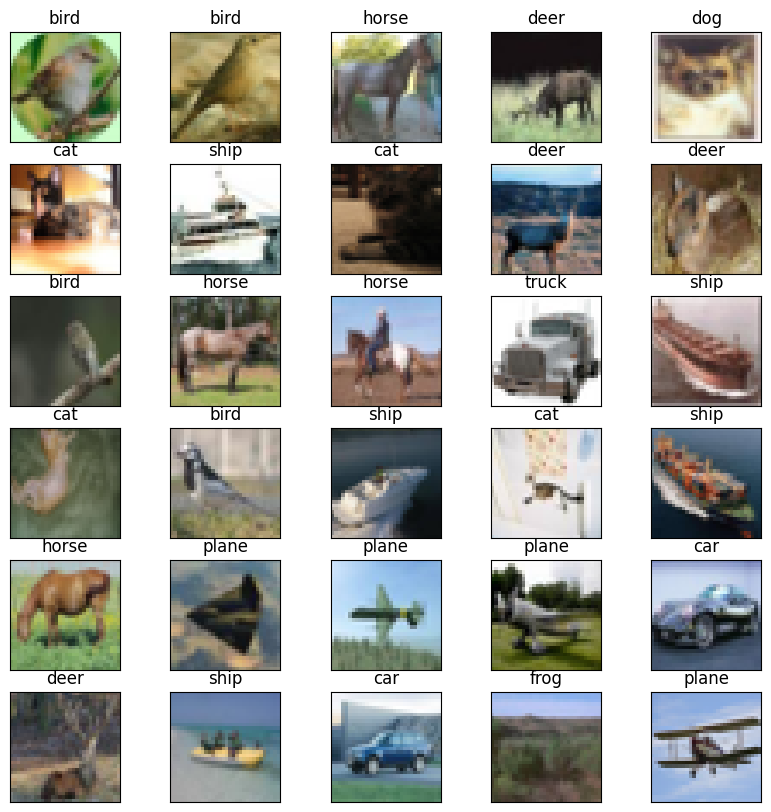

In [5]:
visualize_images()

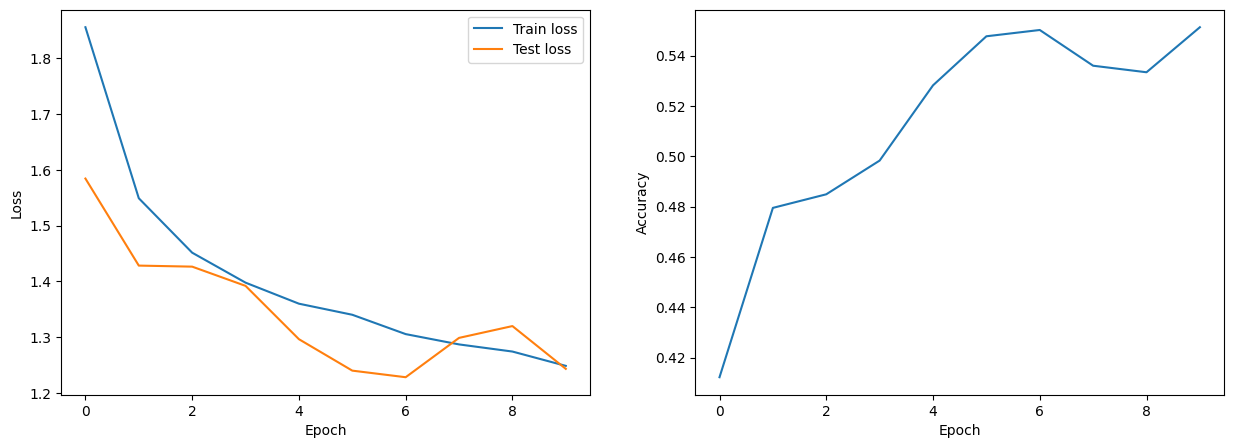

In [ ]:
config, model, train_losses, test_losses, accuracies = load_experiment(
    f"/content/experiments/{exp_name}/"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.show()

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


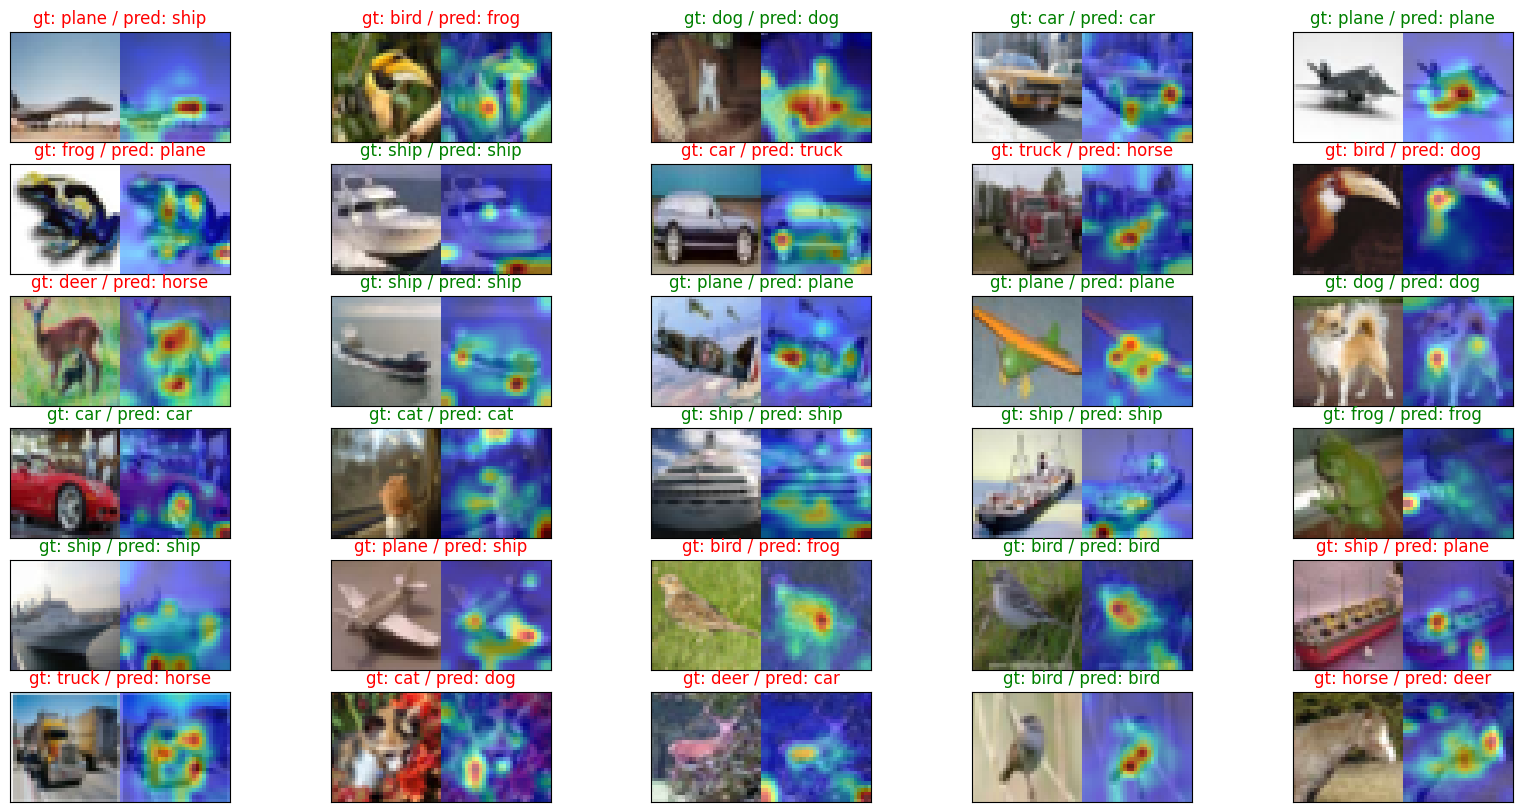

In [ ]:
visualize_attention(model, "attention.png")